In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matching.glema.common.utils.io_utils as io_utils

In [50]:
def extract_prefix( filename ):
    # Split the filename on underscores.
    parts = filename.split( '_' )

    prefix_parts = [ ]
    for part in parts:
        # If the part starts with a digit, assume it's the start of the timestamp.
        if part and part[ 0 ].isdigit():
            break
        prefix_parts.append( part )

    # Join the parts back together with underscores.
    return '_'.join( prefix_parts )


extract_prefix( "run-CPG_augm_large_CPG_augm_large_undirected_anchored_v1_2024-12-30T09-34-tag-batch_acc.csv" )

'run-CPG_augm_large_CPG_augm_large_undirected_anchored_v1'

In [54]:
batch_runs_dir = "./model_runs/batch/"
train_runs_dir = "./model_runs/train/"
test_runs_dir = "./model_runs/test/"

BATCH_KEY = "batch"
TRAIN_KEY = "train"
TEST_KEY = "test"
LOSS_KEY = "loss"
ACC_KEY = "acc"
ROC_KEY = "roc"

KEY_MAPPING = {
    BATCH_KEY: "Train Batch",
    TRAIN_KEY: "Train Epoch",
    TEST_KEY: "Test Epoch",
    f"{BATCH_KEY}_step": "Batch",
    f"{TRAIN_KEY}_step": "Epoch",
    f"{TEST_KEY}_step": "Epoch",
    LOSS_KEY: "Loss",
    ACC_KEY: "Accuracy",
    ROC_KEY: "ROC AUC",
    1: "higher is better",
    -1: "lower is better"
}

SCALAR_TARGET: dict[ str, int ] = {
    LOSS_KEY: -1,
    ACC_KEY: 1,
    ROC_KEY: 1
}

dfs: dict[ str, dict[ str, dict[ str, pd.DataFrame ] ] ] = {
    BATCH_KEY: { LOSS_KEY: { }, ACC_KEY: { } },
    TRAIN_KEY: { LOSS_KEY: { }, ACC_KEY: { }, ROC_KEY: { } },
    TEST_KEY: { LOSS_KEY: { }, ACC_KEY: { }, ROC_KEY: { } },
}

for run_dir in [ batch_runs_dir, train_runs_dir, test_runs_dir ]:
    for run_file in io_utils.get_filenames_in_dir( run_dir ):
        for run in dfs.keys():
            if run in run_file:
                run_dfs = dfs[ run ]
                for scalar in run_dfs.keys():
                    if run_file.endswith( f"{scalar}.csv" ):
                        run_name = extract_prefix( run_file )
                        print( f"Add df {run} {scalar}: {run_name}" )
                        run_df = pd.read_csv( f"{run_dir}{run_file}" )
                        run_dfs[ scalar ][ extract_prefix( run_name ) ] = run_df

Add df batch acc: run-CPG_augm_large_directed_CPG_augm_large_directed_anchored_v2
Add df batch acc: run-CPG_augm_large_CPG_augm_large_undirected_v1
Add df batch loss: run-CPG_augm_large_CPG_augm_large_undirected_anchored_v1
Add df batch loss: run-CPG_augm_large_directed_CPG_augm_large_directed_anchored_v2
Add df batch loss: run-dpdf_dpdf_undirected_anchored_v2
Add df batch acc: run-CPG_augm_large_CPG_augm_large_undirected_anchored_v1
Add df batch loss: run-CPG_augm_large_CPG_augm_large_undirected_v1
Add df batch acc: run-dpdf_dpdf_undirected_anchored_v2
Add df train acc: run-CPG_augm_large_CPG_augm_large_undirected_anchored_v1
Add df train loss: run-dpdf_dpdf_undirected_anchored_v2
Add df train roc: run-CPG_augm_large_CPG_augm_large_undirected_v1
Add df train roc: run-CPG_augm_large_directed_CPG_augm_large_directed_anchored_v2
Add df train loss: run-CPG_augm_large_directed_CPG_augm_large_directed_anchored_v2
Add df train acc: run-dpdf_dpdf_undirected_anchored_v2
Add df train loss: run-

In [58]:
list( dfs[ BATCH_KEY ][ LOSS_KEY ].values() )[ 0 ]

,Wall time,Step,Value
0,1.735548e+09,120,2.323623
1,1.735548e+09,380,1.849614
2,1.735548e+09,500,1.558349
3,1.735548e+09,820,1.650524
4,1.735548e+09,860,1.607809
...,...,...,...
995,1.735564e+09,109060,0.263302
996,1.735564e+09,109080,0.250974
997,1.735564e+09,109120,0.250884
998,1.735564e+09,109220,0.263010


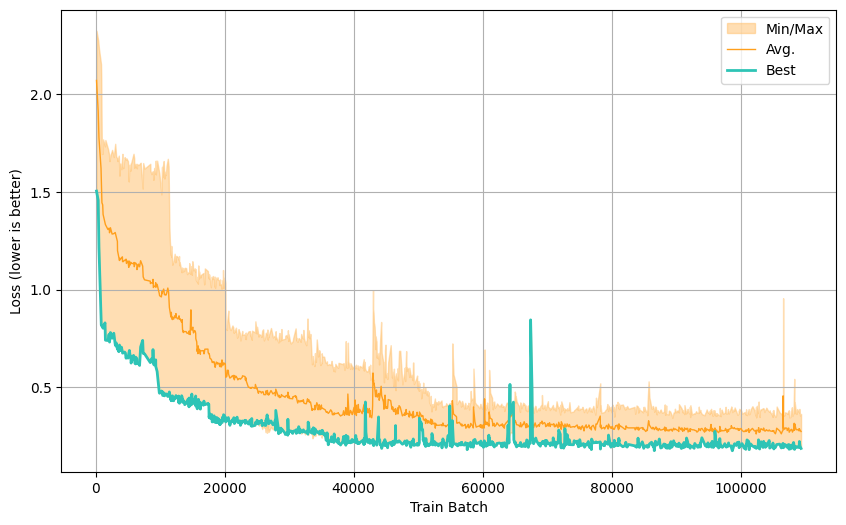

In [60]:
HIGHLIGHT_COLOR = "#69A9FF"
PRIMARY_COLOR = "#FF9F1C"
PRIMARY_COLOR_LIGHT = "#FFBF69"
SECONDARY_COLOR_LIGHT = "#CBF3F0"
SECONDARY_COLOR = "#2EC4B6"

STEP_COL = "Step"
VALUE_COL = "Value"


def plot_fill_between( dfs: dict, run: str, scalar: str ):
    run_dfs = dfs[ run ][ scalar ].values()

    if len( run_dfs ) < 2:
        return

    # Determine the minimum number of rows across all dfs to align the steps.
    min_length = min( len( df ) for df in run_dfs )
    trimmed_dfs = [ df.iloc[ :min_length ].copy() for df in run_dfs ]

    # Assume that the steps are aligned across dataframes.
    steps = trimmed_dfs[ 0 ][ STEP_COL ].values

    # Stack the 'Value' arrays from each dataframe for element-wise operations.
    values = np.array( [ df[ VALUE_COL ].values for df in trimmed_dfs ] )

    # Calculate the overall min, max and average for each step.
    average = np.mean( values, axis=0 )
    lower_bound = np.min( values, axis=0 )
    upper_bound = np.max( values, axis=0 )

    # Identify best run
    final_values = [ df[ VALUE_COL ].iloc[ -1 ] for df in trimmed_dfs ]
    if SCALAR_TARGET[ scalar ] < 0:
        # Select the dataframe with the lowest final value.
        best_run_idx = np.argmin( final_values )
    else:
        # Select the dataframe with the highest final value.
        best_run_idx = np.argmax( final_values )
    best_run = trimmed_dfs[ best_run_idx ][ VALUE_COL ].values

    # Create the plot.
    plt.figure( figsize=(10, 6) )

    # Fill the area between the min and max values.
    plt.fill_between( steps, lower_bound, upper_bound, color=PRIMARY_COLOR_LIGHT, alpha=0.5,
                      label=f"Min/Max" )

    # Plot the average line.
    plt.plot( steps, average, color=PRIMARY_COLOR, linewidth=1, label=f"Avg." )

    # Plot best run.
    plt.plot( steps, best_run, color=SECONDARY_COLOR, linewidth=2, label=f"Best" )

    # Configure the plot.
    plt.xlabel( KEY_MAPPING[ run ] )
    plt.ylabel( f"{KEY_MAPPING[ scalar ]} ({KEY_MAPPING[ SCALAR_TARGET[ scalar ] ]})" )
    #plt.title( f"{run} {scalar}" )
    plt.legend()
    plt.grid( True )

    plt.savefig( f"plots/model_{run}_{scalar}" )


plot_fill_between( dfs, BATCH_KEY, LOSS_KEY )

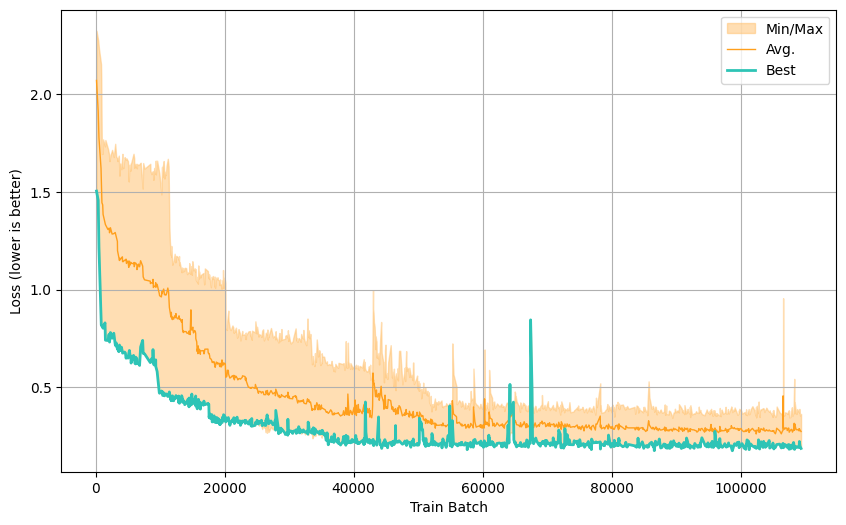

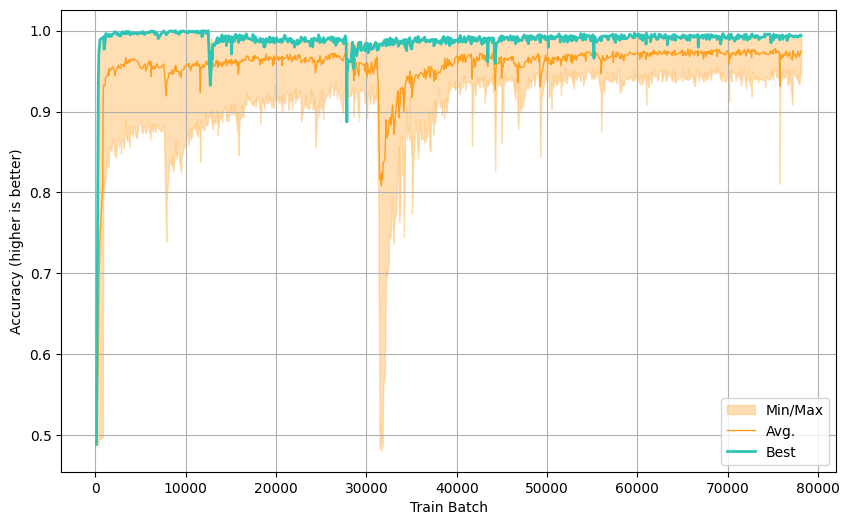

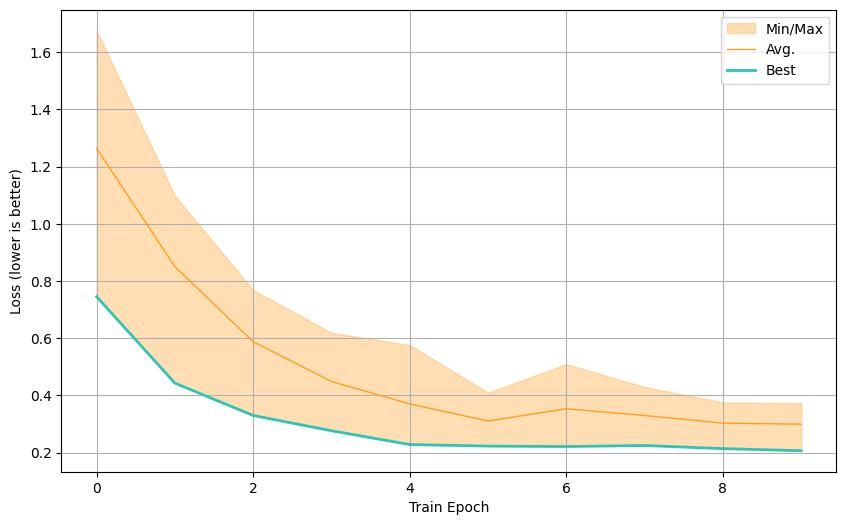

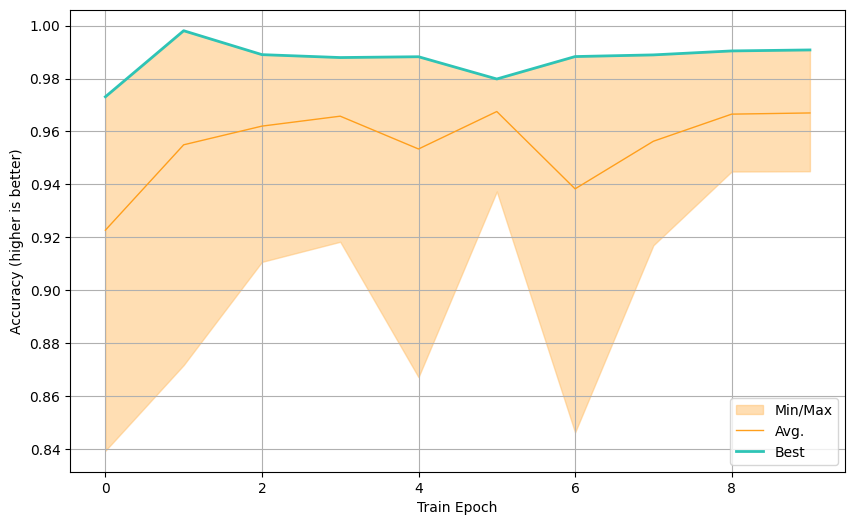

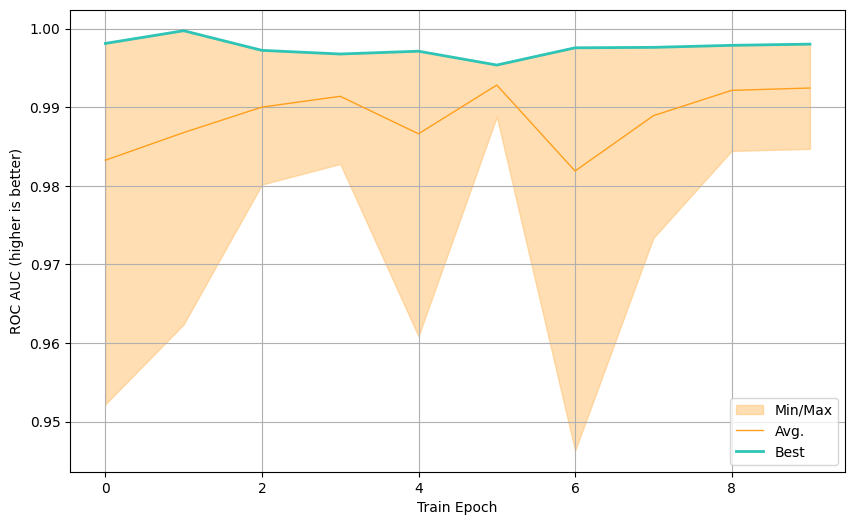

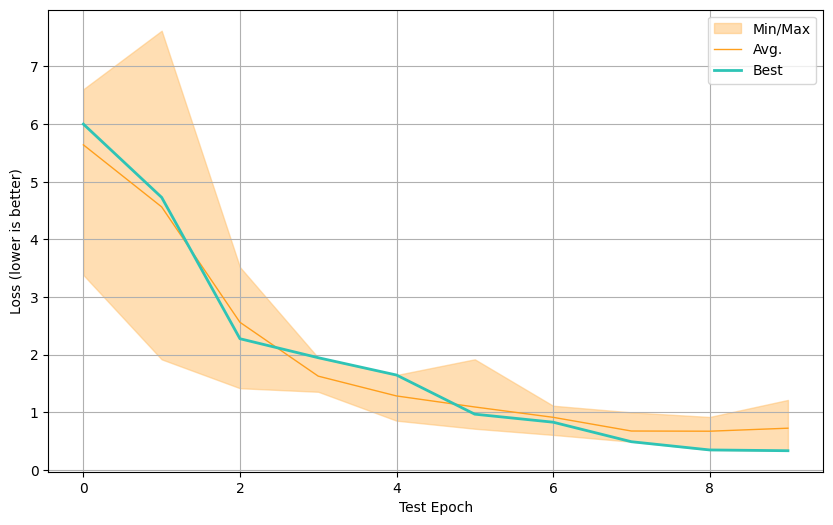

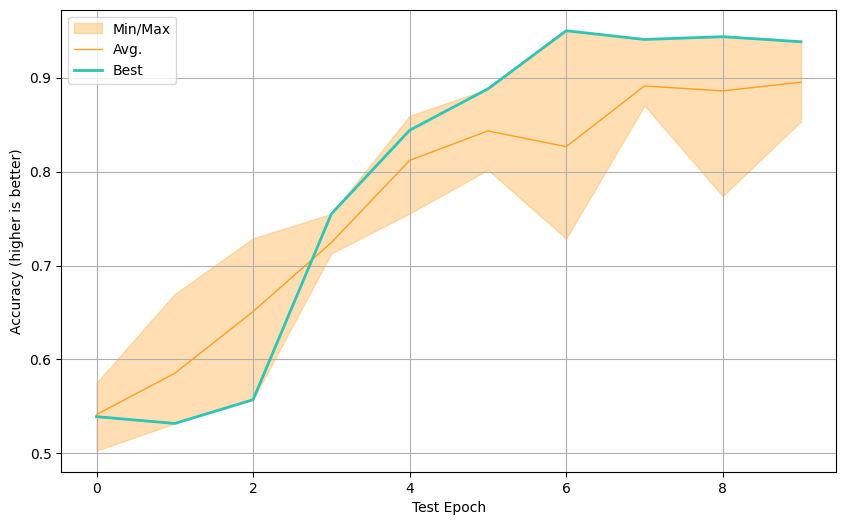

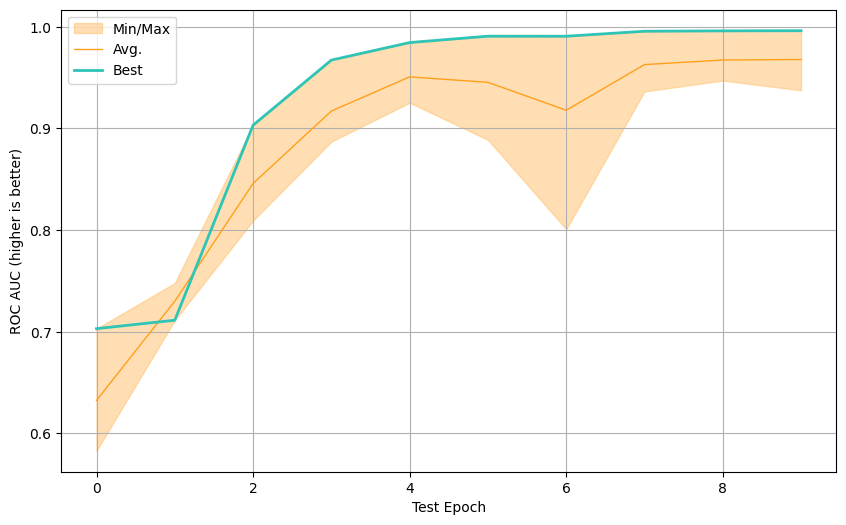

In [61]:
for run in dfs.keys():
    for scalar in dfs[ run ].keys():
        plot_fill_between( dfs, run, scalar )